In [1]:
import sys
sys.path.append('/home/jonathan/Dropbox/jonathanmain/CGM/rapidCoolingCGM/pysrc/')

In [2]:
import FIRE_files as ff
import simulationFiles
import time, importlib
import pylab as pl, numpy as np, glob, pdb
from matplotlib import ticker, gridspec
from numpy import log10 as log
import astropy
from astropy import units as un, constants as cons

In [3]:
figDir = '../figures/'

In [4]:
simnames = ('m12i','m12b','m12c','m11d')
resolution = 7100
simgroup = 'md'

In [5]:
ff.pyobjDir = '../profiles_files/'

In [6]:

Mdot_0 = {}; Mdot_1 = {}; Mdot_2 = {}
profs = [None]*4
snapshots = np.arange(590,550,-1)[:]
for isim,simname1 in enumerate(simnames):
    Mdot_0[isim]     = np.ones((len(snapshots),ff.Snapshot_profiler.log_r2rvir_bins.shape[0]-1))*np.nan
    Mdot_1[isim]     = np.ones((len(snapshots),ff.Snapshot_profiler.log_r2rvir_bins.shape[0]-1))*np.nan
    Mdot_2[isim]     = np.ones((len(snapshots),ff.Snapshot_profiler.log_r2rvir_bins.shape[0]-1))*np.nan
    for i,iSnapshot in enumerate(snapshots):
#         meta1 = ff.Snapshot_meta(simname1,simgroup,resolution, iSnapshot=iSnapshot,
#                                      **simulationFiles.simulationFiles_dic[(simname1,resolution,simgroup)])
#         snapshot1 = ff.Snapshot(meta1,pr=False,loadAll=False)
#         prof1 = ff.Snapshot_profiler(snapshot1)
        profs[isim] = prof1 = ff.Snapshot_profiler((simname1,simgroup,str(resolution), ff.z_from_iSnapshot(iSnapshot)))
        prof1.load(loadAll=True)
        if isim<2:
            Mdot_0[isim][i,:] = prof1.MdotProfile([1e5,1e10],suffix='_hot_nodisc2')
            Mdot_1[isim][i,:] = prof1.MdotProfile(T_range=[5e3,1e5],suffix='_cool_nodisc5')
            Mdot_2[isim][i,:] = prof1.MdotProfile(T_range=[10,5e3],suffix='_cool_nodisc6')
        else:
            Mdot_0[isim][i,:] = prof1.MdotProfile([1e5,1e10],suffix='_hot')
            Mdot_1[isim][i,:] = prof1.MdotProfile(T_range=[5e3,1e5],suffix='_cool')
            Mdot_2[isim][i,:] = prof1.MdotProfile(T_range=[10,5e3],suffix='_cold')            
        prof1.tofile()
        if i==0: print(prof1.Tvir())

646985.198927783
737487.9558871578
721488.1769181559
275407.3671477457


In [11]:
import h5py
ZachData = h5py.File('../data/summary.hdf5')

In [9]:
f_thin = [ZachData['thin_disk_fraction_recent'][s+'_'+simgroup].value for s in simnames]

/home/jonathan/miniconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [10]:
ZachData.keys()

<KeysViewHDF5 ['R1e5K', 'R1e5K_rgal', 'circularity', 'cosphi', 'cosphi_stars', 'f_thin_tracked_z0', 'n_tracked', 'quiet_acc_fraction', 'thick_disk_fraction', 'thick_disk_fraction_recent', 'thin_disk_fraction', 'thin_disk_fraction_recent', 'tracked_mass_z0', 'tracked_star_mass_z0']>

In [31]:
[ZachData['Rstar0.5'][s+'_'+simgroup].value for s in simnames]

KeyError: "Unable to open object (object 'Rstar0.5' doesn't exist)"

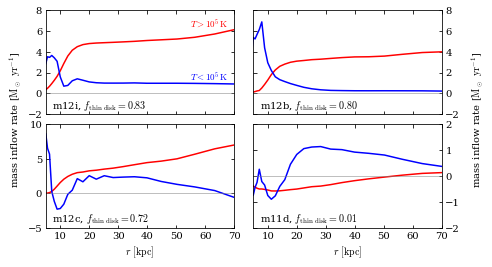

In [30]:
N = 5
fig = pl.figure(figsize=(ff.pB.fig_width_full,4))
pl.subplots_adjust(wspace=0.1,hspace=0.1)
for isim,simname1 in enumerate(('m12i','m12b','m12c','m11d')):
    ax = pl.subplot(2,2,isim+1)
    Mdots = Mdot_0[isim],Mdot_1[isim]+Mdot_2[isim]
    cs = 'rbc'
    for i,Mdot in enumerate(Mdots):
        med = np.average(Mdot[:],axis=0)
        med_binned = np.average(med[:N*(med.shape[0]//N)].reshape(med.shape[0]//N,N),axis=1)        
        pl.plot(prof1.rs_midbins()[N//2:N*(med.shape[0]//N):N],-med_binned,c=cs[i])        
    pl.xlim(5,70)            
    pl.axhline(0,c='.5',ls='-',lw=0.5)
    if isim==0:        
        pl.text(68,6.35,r'$T>10^5\,{\rm K}$',     c='r',ha='right',fontsize=9)
        pl.text(68,1.2,r'$T<10^5\,{\rm K}$',c='b',ha='right',fontsize=9)
        yrng = np.array([-2,8])
#         pl.text(68,-0.75,r'$T<5000\,{\rm K}$',     c='c',ha='right',fontsize=9)

        pl.ylim(-2,8)
    if isim==1: yrng = np.array([-2,8])
    if isim==2: yrng = np.array([-5,10])
    if isim==3: yrng = np.array([-2,2])
    pl.ylim(*yrng)
#     pl.plot([0.1*profs[isim].rvir]*2,
#             yrng[0]+np.array([0.95,1.05])*(yrng[1]-yrng[0]),
#             c='k',lw=0.7,clip_on=False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
#     ax.xaxis.set_ticks_position('bottom')
    if not ax.is_last_row():
        ax.xaxis.set_major_formatter(ticker.NullFormatter())
    else:
        pl.xlabel(r'$r\ [{\rm kpc}]$')
    if ax.is_last_col():
        ax.yaxis.set_label_position('right')
        ax.yaxis.set_ticks_position('right')
        ax.yaxis.set_ticks_position('both')
    pl.text(0.035,0.055,r'%s, $f_{\rm thin~disk}= %.2f$'%(simname1,f_thin[isim]), transform=ax.transAxes)
for x in 0.065,0.97:
    pl.text(x,.5,r'mass inflow rate [${\rm M}_\odot\ {\rm yr}^{-1}$]',
        ha='center',va='center',rotation=90,transform=fig.transFigure)
pl.savefig(figDir+'Mdot_all_halo.pdf',bbox_inches='tight')

In [5]:
Mdot_0 = {}; Mdot_1 = {}; Mdot_2 = {}; Edot_grav = {}; Edot_comp = {}; Edot_cool = {}; Edot_advec = {}; SFRs = {}; SFRs2 = {}
snapshots = np.arange(590,550,-1)[:]
for isim,simname1 in enumerate(('m12i','m12b')[:]):
    Mdot_0[isim]     = np.ones((len(snapshots),ff.Snapshot_profiler.log_r2rvir_bins.shape[0]-1))*np.nan
    Mdot_1[isim]     = np.ones((len(snapshots),ff.Snapshot_profiler.log_r2rvir_bins.shape[0]-1))*np.nan
    Mdot_2[isim]     = np.ones((len(snapshots),ff.Snapshot_profiler.log_r2rvir_bins.shape[0]-1))*np.nan
    Edot_grav[isim]  = np.ones((len(snapshots),ff.Snapshot_profiler.log_r2rvir_bins.shape[0]-1))*np.nan
    Edot_cool[isim]  = np.ones((len(snapshots),ff.Snapshot_profiler.log_r2rvir_bins.shape[0]-1))*np.nan
    Edot_comp[isim]  = np.ones((len(snapshots),ff.Snapshot_profiler.log_r2rvir_bins.shape[0]-1))*np.nan
    Edot_advec[isim] = np.ones((len(snapshots),ff.Snapshot_profiler.log_r2rvir_bins.shape[0]-1))*np.nan
    SFRs[isim]       = np.ones((len(snapshots),ff.Snapshot_profiler.log_r2rvir_bins.shape[0]-1))*np.nan
    SFRs2[isim]      = np.ones((len(snapshots),ff.Snapshot_profiler.log_r2rvir_bins.shape[0]-1))*np.nan
    for i,iSnapshot in enumerate(snapshots):
        meta1 = ff.Snapshot_meta(simname1,simgroup,resolution, iSnapshot=iSnapshot,
                                     **simulationFiles.simulationFiles_dic[(simname1,resolution,simgroup)])
        snapshot1 = ff.Snapshot(meta1,pr=False,loadAll=False)
        prof1 = ff.Snapshot_profiler(snapshot1)
        prof1.load(loadAll=True)
#         print (iSnapshot, prof1.z,ff.cosmo.age(0)-ff.cosmo.age(prof1.z))
        Mdot_0[isim][i,:] = prof1.MdotProfile([1e5,1e10],suffix='_hot_nodisc2')
        Mdot_1[isim][i,:] = prof1.MdotProfile(T_range=[5e3,1e5],suffix='_cool_nodisc5')
        Mdot_2[isim][i,:] = prof1.MdotProfile(T_range=[10,5e3],suffix='_cool_nodisc6')
        SFRs[isim][i,:] = prof1.SFRprofile().cumsum()
        SFRs2[isim][i,:] = prof1.SFRprofile()
        g = prof1.vc()**2 / prof1.rs_midbins()
        Edot_grav[isim][i,:] = g * (Mdot_0[isim][i,:]+Mdot_1[isim][i,:]+Mdot_2[isim][i,:])
        Edot_grav[isim][i,:] *= (un.Msun/un.yr * (un.km/un.s)**2 * un.kpc**-1).to('erg*s**-1*kpc**-1')
        _Edot_advec = prof1.MdotProfile(isEdot=True)* un.s.to('yr')
        Edot_advec[isim][i,:] = np.pad(_Edot_advec[2:]-_Edot_advec[:-2],1,'edge')/2./prof1.drs_midbins()        
        Edot_cool[isim][i,:] = (prof1.profile1D('rad_per_unit_mass_max_nH','MW',minT=1e5) * prof1.gasMassProfile() / prof1.drs_midbins())
        Edot_cool[isim][i,:] *= (un.erg * un.s**-1 *un.g**-1 * un.Msun * un.kpc**-1).to('erg*s**-1*kpc**-1')
        nHTs  = prof1.profile1D('nHTs','VW')
        dnHTs = np.pad(nHTs[2:] - nHTs[:-2],1,'edge')/2.
        vrs = prof1.profile1D('vrs','VW')*un.km/un.s
        dvrs = np.pad(vrs[2:]-vrs[:-2],1,'edge')/2.*un.km/un.s
        Ps = 2.3*cons.k_B*nHTs*un.K*un.cm**-3 
        dPs = 2.3*cons.k_B*dnHTs*un.K*un.cm**-3 
        Edot_comp[isim][i,:] = ( (-dPs*vrs + Ps*dvrs) *
                                4*np.pi*prof1.rs_midbins()**2/prof1.drs_midbins()*un.kpc).to('erg*s**-1*kpc**-1')
        prof1.tofile()

/scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100/output/snapdir_590/snapshot_590.0.hdf5
loaded PartType0, InternalEnergy
loaded PartType0, Velocities
loaded PartType0, Coordinates
loaded PartType0, Masses
saved Mdot_hot_nodisc2


KeyboardInterrupt: 

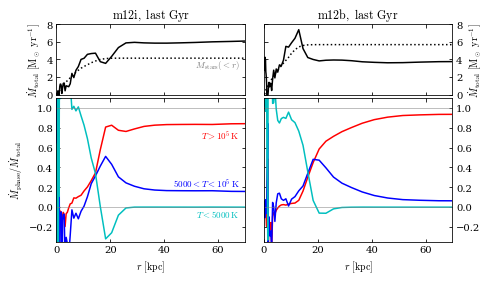

In [15]:
N = 5
fig = pl.figure(figsize=(ff.pB.fig_width_full,4))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig,wspace=0.1,hspace=0.05)
for isim,simname1 in enumerate(('m12i','m12b')):
    Mtotals = Mdot_0[isim]+Mdot_1[isim]+Mdot_2[isim]
    Mtotals_med = np.average(Mtotals[:],axis=0)
    Mtotals_med_binned = np.average(Mtotals_med[:N*(Mtotals_med.shape[0]//N)].reshape(Mtotals_med.shape[0]//N,N),axis=1)
    for iRow in range(2):
        if iRow==0: 
            ax = fig.add_subplot(spec[0,isim])
            Mdots = -Mtotals,SFRs[isim]/2
            cs = 'k','k'
        if iRow==1: 
            ax = fig.add_subplot(spec[1:,isim])
            Mdots = Mdot_0[isim],Mdot_1[isim],Mdot_2[isim]
            cs = 'rbc'
        for i,Mdot in enumerate(Mdots):
            med = np.average(Mdot[:],axis=0)
            med_binned = np.average(med[:N*(med.shape[0]//N)].reshape(med.shape[0]//N,N),axis=1)
            if iRow==1: med_binned/=Mtotals_med_binned
            pl.plot(prof1.rs_midbins()[N//2:N*(med.shape[0]//N):N],med_binned,c=cs[i],ls=('-',':')[iRow==0 and i==1])        
        pl.xlim(0,70)        
        if iRow==0: 
            pl.ylim(0,8)
            pl.ylabel(r'$\dot{M}_{\rm total}\ [{\rm M}_\odot\ {\rm yr}^{-1}]$')    
            pl.title(r'${\rm %s,\ last\ Gyr}$'%simname1)
            ax.xaxis.set_major_formatter(ticker.NullFormatter())
            ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
            if isim==0:
                pl.text(68,3,r'$\dot{M}_{\rm stars}(<r)$',     c='grey',ha='right',fontsize=9)
        else:
            pl.ylim(-0.35,1.1)            
            pl.xlabel(r'$r\ [{\rm kpc}]$')
            pl.axhline(0,c='.5',ls='-',lw=0.5)
            pl.axhline(1,c='.5',ls='-',lw=0.5)
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
            if isim==0:
                pl.ylabel(r'$\dot{M}_{\rm phase} / \dot{M}_{\rm total}$')
                #     #         pl.text(0.05*prof1.rvir,6.8,r'$0.05\ R_{\rm vir}$',fontsize=9)
                pl.text(68,0.69,r'$T>10^5\,{\rm K}$',     c='r',ha='right',fontsize=9)
                pl.text(68,0.2,r'$5000<T<10^5\,{\rm K}$',c='b',ha='right',fontsize=9)
                pl.text(68,-0.1,r'$T<5000\,{\rm K}$',     c='c',ha='right',fontsize=9)
        if isim==1:
            ax.yaxis.set_label_position('right')
            ax.yaxis.set_ticks_position('right')
            ax.yaxis.set_ticks_position('both')
pl.savefig(figDir+'Mdot_normalized.pdf',bbox_inches='tight')

In [ ]:
10

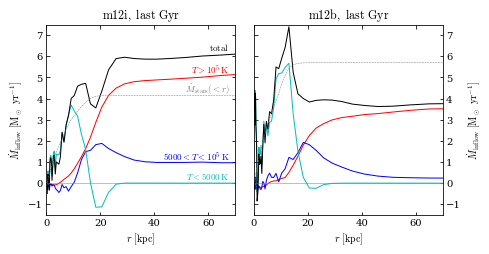

In [10]:
N = 5
pl.figure(figsize=(ff.pB.fig_width_full,3.5))
pl.subplots_adjust(wspace=0.1)
for isim,simname1 in enumerate(('m12i','m12b')):
    ax=pl.subplot(1,2,isim+1)
    for i,Mdot in enumerate((Mdot_0[isim],Mdot_1[isim],Mdot_2[isim],
                             Mdot_0[isim]+Mdot_1[isim]+Mdot_2[isim],
                             SFRs[isim]/2)):
        med = np.average(Mdot[:],axis=0)
        med_binned = np.average(med[:N*(med.shape[0]//N)].reshape(med.shape[0]//N,N),axis=1)
        if i!=4: med_binned = -med_binned
        pl.plot(prof1.rs_midbins()[N//2:N*(med.shape[0]//N):N],med_binned,
                c=('r','b','c','k','grey')[i],lw=(1,0.5)[i==4],ls=('-','--')[i==4])
#     pl.axvline(0.05*prof1.rvir,c='.5',ls='-',lw=0.5)    
    pl.axhline(0,c='.5',ls='-',lw=0.5)
    pl.xlim(0,70)
    pl.ylim(-1.5,7.5)
    pl.xlabel(r'$r\ [{\rm kpc}]$')
    pl.title(r'${\rm %s,\ last\ Gyr}$'%simname1)
    pl.ylabel(r'$\dot{M}_{\rm inflow}\ [{\rm M}_\odot\ {\rm yr}^{-1}]$')    
    if isim==0:
#         pl.text(0.05*prof1.rvir,6.8,r'$0.05\ R_{\rm vir}$',fontsize=9)
        pl.text(68,6.3,r'${\rm total}$',         c='k',ha='right',fontsize=9)
        pl.text(68,5.2,r'$T>10^5\,{\rm K}$',     c='r',ha='right',fontsize=9)
        pl.text(68,1.1,r'$5000<T<10^5\,{\rm K}$',c='b',ha='right',fontsize=9)
        pl.text(68,4.3,r'$\dot{M}_{\rm stars}(<r)$',     c='grey',ha='right',fontsize=9)
        pl.text(68,0.2,r'$T<5000\,{\rm K}$',     c='c',ha='right',fontsize=9)
    else:
        ax.yaxis.set_label_position('right')
        ax.yaxis.set_ticks_position('right')
        ax.yaxis.set_ticks_position('both')
pl.savefig(figDir+'Mdot.pdf',bbox_inches='tight')

/home1/04613/tg839127/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2146: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xf >= v1) & (xf <= v2)
/home1/04613/tg839127/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2146: RuntimeWarning: invalid value encountered in less_equal
  condition = (xf >= v1) & (xf <= v2)
/home1/04613/tg839127/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2146: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xf >= v1) & (xf <= v2)
/home1/04613/tg839127/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2146: RuntimeWarning: invalid value encountered in less_equal
  condition = (xf >= v1) & (xf <= v2)


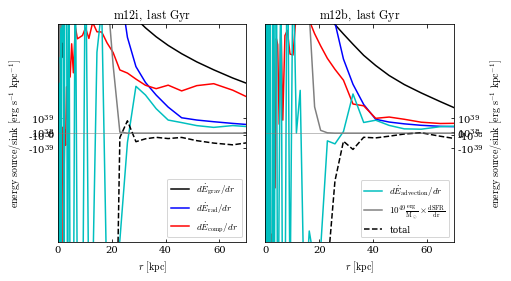

In [7]:
normy=1
N = 5
pl.figure(figsize=(ff.pB.fig_width_full,4))
pl.subplots_adjust(wspace=0.1)
for isim,simname1 in enumerate(('m12i','m12b')[:]):
    ax=pl.subplot(1,2,isim+1)
    Efeedback = SFRs2[isim]*1e49*un.s.to('yr')
    for i,Edot in enumerate((-Edot_grav[isim],Edot_cool[isim],-Edot_comp[isim],Edot_advec[isim],Efeedback,
                            -Edot_grav[isim]+Efeedback+Edot_comp[isim]- (Edot_advec[isim]+Edot_cool[isim]))):
        med = np.average(Edot,axis=0)
        med_binned = np.average(med[:N*(med.shape[0]//N)].reshape(med.shape[0]//N,N),axis=1)
        label = (r'$d\dot{E}_{\rm grav}/dr$',
                 r'$d\dot{E}_{\rm rad}/dr$',
                r'$d\dot{E}_{\rm comp}/dr$',
                 r'$d\dot{E}_{\rm advection}/dr$',
                 r'$10^{49}\frac{\rm erg}{{\rm M}_\odot}\times\frac{d{\rm SFR}}{dr}$','total')[i]
        if i>2 and isim==0 or i<=2 and isim==1: label = '_'
        pl.plot(prof1.rs_midbins()[N//2:N*(med.shape[0]//N):N],med_binned/normy,c=('k','b','r','c','grey','k')[i],
                label=label,ls=('-','--')[i==5])
    pl.axhline(0,c='.5',ls='-',lw=0.5)
    pl.xlim(0,70)
    ax.set_yscale('symlog',linthreshy=1e39,linscaley=0.1)
    pl.ylim(-0.5e40,0.5e40)
    pl.xlabel(r'$r\ [{\rm kpc}]$')
    pl.title(r'${\rm %s,\ last\ Gyr}$'%simname1)
    pl.ylabel(r'${\rm energy\ source/sink}\ [{\rm erg}\ {\rm s}^{-1}\ {\rm kpc}^{-1}]$')    
    pl.legend(fontsize=9)
    if isim==1:
        ax.yaxis.set_label_position('right')
        ax.yaxis.set_ticks_position('right')
        ax.yaxis.set_ticks_position('both')
pl.savefig(figDir+'Edot.pdf',bbox_inches='tight')